In [3]:
%run _utils.ipynb

In [6]:
# Built in issues notebook
gk_issues = load_gk_issues_for_analysis()
non_gk_issues = load_non_gk_issues_for_analysis()

In [10]:
issues = load_issues()
comments = load_comments()
non_gkirbbi_comments = load_non_gkirbbi_comments()
non_gkirbbi_comments = non_gkirbbi_comments[non_gkirbbi_comments['issue_id'].isin(non_gk_issues['id'])]

In [11]:
comments['comment_user_type'].value_counts()

Bot     354901
User     10724
Name: comment_user_type, dtype: int64

<h3><b><i>How many comments do in-range breaking build issue reports have in total, from GK and from actual developers?</i></b></h3>

In [12]:
proportions = (
    comments['comment_user_login'].value_counts() / 
    comments['comment_user_login'].count()
).to_frame(name='proportion')\
    .rename_axis('comment_user_login')\
    .reset_index()
print(proportions.head())

  comment_user_login  proportion
0   greenkeeper[bot]    0.968741
1             ljharb    0.001636
2         ryanhefner    0.001037
3               gr2m    0.000714
4          derhuerst    0.000542


<h3>User Comments Analysis</h3>

In [13]:
users_comments = (
    comments[
        comments['comment_user_type'] == 'User'
    ].copy()
    .reset_index(drop=True)
)
issues_with_user_comment = (
    gk_issues[gk_issues['id']
        .isin(users_comments['comment_issue_id'])]
        .copy()
        .reset_index(drop=True)
)
percent_of_issues_with_user_comment = f'{calculate_percent(len(issues_with_user_comment), len(gk_issues))}%'
print(f'{percent_of_issues_with_user_comment} of in-range issues have a comment from a user.')

9.3% of in-range issues have a comment from a user.


In [14]:
ngkir_user_comments = (
    non_gkirbbi_comments[
        non_gkirbbi_comments['user_type'] == 'User'
    ].copy()
    .reset_index(drop=True)
)

ngkirs_w_user_comment = (
    non_gk_issues[
        non_gk_issues['id'].isin(ngkir_user_comments['issue_id'])
    ]
    .copy()
    .reset_index(drop=True)
)

percent_of_ngkirs_with_user_comment = f'{calculate_percent(len(ngkirs_w_user_comment), len(non_gk_issues))}%'
print(f'{percent_of_ngkirs_with_user_comment} of non-GKIRs have a comment from a user.')

74.61% of non-GKIRs have a comment from a user.


<h3><b>Intra-project comparison of how many IRs have a user comment</b></h3>

In [9]:
# Writing out CSV for creating non_gkirbbi_comments
# for_csv = non_gk_issues[['id', 'repo_name', 'comments_url']]
# for_csv.to_csv(f'../csv/issues_to_collect_comments_for.csv', index=False)

In [10]:
# non_gkirbbi_comments = load_non_gkirbbi_comments()
# print(f'Count of unique projects: {non_gkirbbi_comments["repo_name"].nunique()}')

Count of unique projects: 6898


In [11]:
# Calculate the proportion of non-GKIRs that have a comment from a developer for each project
non_gk_issues_simp = non_gk_issues[['id', 'repo_name']].copy()
ngkir_w_comments = non_gk_issues_simp.merge(
    non_gkirbbi_comments[['issue_id', 'id', 'user_type', 'user_login']],
    how='left',
    left_on='id',
    right_on='issue_id',
    suffixes=['_issue', '_comment']
)

def get_prop_of_ngkirs_with_user_comments(df):
    total_issues = df['id_issue'].nunique()
    total_issues_w_user_comments = df[df['user_type'] == 'User']['id_issue'].nunique()
    return pd.Series([total_issues, total_issues_w_user_comments])

ngkir_repo_issues_with_user_comments = (
    ngkir_w_comments
        .groupby('repo_name')
        .apply(get_prop_of_ngkirs_with_user_comments)
)
ngkir_repo_issues_with_user_comments.columns = ['issue_count', 'issue_w_user_comment_count']
ngkir_repo_issues_with_user_comments['ratio'] = (
    ngkir_repo_issues_with_user_comments['issue_w_user_comment_count'] / ngkir_repo_issues_with_user_comments['issue_count']
)
ngkir_repo_issues_with_user_comments = ngkir_repo_issues_with_user_comments.dropna()
ngkir_repo_issues_with_user_comments = ngkir_repo_issues_with_user_comments.reset_index()

In [12]:
# Calculate the proportion of GKIRs that have a comment from a developer for each project
gk_issues_simp = gk_issues[['id', 'repo_name']].copy()
gkir_w_comments = gk_issues_simp.merge(
    comments[['comment_issue_id', 'comment_id', 'comment_user_type', 'comment_user_login']],
    how='left',
    left_on='id',
    right_on='comment_issue_id',
    suffixes=['_issue', '_comment']
)

def get_prop_of_gkirs_with_user_comments(df):
    total_issues = df['id'].nunique()
    total_issues_w_user_comments = df[df['comment_user_type'] == 'User']['id'].nunique()
    return pd.Series([total_issues, total_issues_w_user_comments])

gkir_repo_issues_with_user_comments = (
    gkir_w_comments
        .groupby('repo_name')
        .apply(get_prop_of_gkirs_with_user_comments)
)
gkir_repo_issues_with_user_comments.columns = ['issue_count', 'issue_w_user_comment_count']
gkir_repo_issues_with_user_comments['ratio'] = (
    gkir_repo_issues_with_user_comments['issue_w_user_comment_count'] / gkir_repo_issues_with_user_comments['issue_count']
)
gkir_repo_issues_with_user_comments = gkir_repo_issues_with_user_comments.dropna()
gkir_repo_issues_with_user_comments = gkir_repo_issues_with_user_comments.reset_index()

In [13]:
# Merge the two DFs 
merged = ngkir_repo_issues_with_user_comments.merge(
    gkir_repo_issues_with_user_comments,
    how='inner',
    on='repo_name',
    suffixes=['_ngkir', '_gkir'],
)


def calc_ratio(row):
    if row['ratio_ngkir'] == 0:
        if row['ratio_gkir'] == 0:
            return 1
        else:
            return row['ratio_gkir']
    else:
        return row['ratio_gkir'] / row['ratio_ngkir']

merged['gk_to_ngk'] = merged.apply(calc_ratio, axis=1)
merged['gk_to_ngk'].median()

0.09722222222222222

In [14]:
# non_gkirbbi_comments = load_non_gkirbbi_comments()
# print(f'Count of unique projects: {non_gkirbbi_comments["repo_name"].nunique()}')

# Determine time until first user comment on non-gk issues
non_gkirbbi_user_comments = non_gkirbbi_comments.loc[
    (non_gkirbbi_comments['user_type'] == 'User') &
    (~non_gkirbbi_comments['issue_id'].isin(gk_issues_with_first_user_comments['id']))
]
non_gkirbbi_first_user_comments = (
    non_gkirbbi_user_comments
        .groupby('issue_id')['created_at']
        .min()
        .to_frame()
        .reset_index()   
)
non_gkirbbi_with_first_comment = non_gkirbbi_first_user_comments.merge(
    non_gk_issues[['id', 'repo_name', 'created_at']],
    how='inner',
    left_on='issue_id',
    right_on='id',
    suffixes=['_comment', '_issue']
)
non_gkirbbi_with_first_comment['time_to_comment'] = \
    non_gkirbbi_with_first_comment['created_at_comment'] - non_gkirbbi_with_first_comment['created_at_issue']

# Find what the mean and median time to first user comment on non-gk issues at project level
non_gkirbbi_with_first_comment__simplified = \
    non_gkirbbi_with_first_comment[['id', 'repo_name', 'time_to_comment']].copy()

non_gkirbbi_with_first_comment__simplified['time_to_comment'] = \
    non_gkirbbi_with_first_comment__simplified['time_to_comment'].dt.total_seconds()  # Have to convert to seconds to calculate mean and median

projects__non_gkirbbi_with_first_user_comment = (
    non_gkirbbi_with_first_comment__simplified
        .groupby('repo_name')['time_to_comment']
        .agg(['mean', 'median'])
        .reset_index()
)

projects__non_gkirbbi_with_first_user_comment = \
    projects__non_gkirbbi_with_first_user_comment[~pd.isna(projects__non_gkirbbi_with_first_user_comment['median'])]

projects__non_gkirbbi_with_first_user_comment['mean'] = pd.to_timedelta(
    projects__non_gkirbbi_with_first_user_comment['mean'],
    unit='s'
)
projects__non_gkirbbi_with_first_user_comment['mean_hours_log'] = np.log10(
    projects__non_gkirbbi_with_first_user_comment['mean'] / np.timedelta64(1, 'h')
)
projects__non_gkirbbi_with_first_user_comment['median'] = pd.to_timedelta(
    projects__non_gkirbbi_with_first_user_comment['median'],
    unit='s'
)
projects__non_gkirbbi_with_first_user_comment['median_hours_log'] = np.log10(
    projects__non_gkirbbi_with_first_user_comment['median'] / np.timedelta64(1, 'h')
)

Count of unique projects: 6898


NameError: name 'gk_issues_with_first_user_comments' is not defined

In [ ]:
gk_issues_with_first_user_comments__simplified = \
    gk_issues_with_first_user_comments[['id', 'repo_name', 'time_to_comment']].copy()

gk_issues_with_first_user_comments__simplified['time_to_comment'] = \
    gk_issues_with_first_user_comments__simplified['time_to_comment'].dt.total_seconds()  # Have to convert to seconds to calculate mean and median

projects__gk_issues_with_first_user_comments = (
    gk_issues_with_first_user_comments__simplified
        .groupby('repo_name')['time_to_comment']
        .agg(['mean', 'median'])
        .reset_index()
)
projects__gk_issues_with_first_user_comments['mean'] = pd.to_timedelta(
    projects__gk_issues_with_first_user_comments['mean'],
    unit='s'
)
projects__gk_issues_with_first_user_comments['mean_hours_log'] = np.log10(
    projects__gk_issues_with_first_user_comments['mean'] / np.timedelta64(1, 'h')
)
projects__gk_issues_with_first_user_comments['median'] = pd.to_timedelta(
    projects__gk_issues_with_first_user_comments['median'],
    unit='s'
)
projects__gk_issues_with_first_user_comments['median_hours_log'] = np.log10(
    projects__gk_issues_with_first_user_comments['median'] / np.timedelta64(1, 'h')
)

In [ ]:
# Merge gk and non-gk project time to user comment by repo_name
project__all_issues__time_to_comment = projects__non_gkirbbi_with_first_user_comment.merge(
    projects__gk_issues_with_first_user_comments,
    how='inner',
    on=['repo_name'],
    suffixes=['_non_gk', '_gk'],
)
# Melt for violine plot
melted = pd.melt(
    project__all_issues__time_to_comment,
    id_vars='repo_name',
    value_vars=['median_hours_log_gk', 'median_hours_log_non_gk'],
    var_name='issue_type',
    value_name='median_time_to_comment_hours_log',
)

melted['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=melted,
    x='median_time_to_comment_hours_log',
    y='placeholder',
    hue='issue_type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Median time to first use comment on issue (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)
ax.legend(
    title='',
)
L = plt.legend()
L.get_texts()[0].set_text('Non-Greenkeeper In-Range Breaking Issue')
L.get_texts()[1].set_text('Greenkeeper In-Range Breaking Issue')
print('--Intra-project comparison for median time to first user comment on non-GK issues & median time to first user comment on GK in-range breaking build issues--')
tfns(project__all_issues__time_to_comment, ['median_non_gk', 'median_gk'], title='')
plt.show()

In [ ]:
project__all_issues__time_to_comment['median_ratio'] = (
    project__all_issues__time_to_comment['median_gk'] / 
    project__all_issues__time_to_comment['median_non_gk']
)
project__all_issues__time_to_comment['mean_ratio'] = (
    project__all_issues__time_to_comment['mean_gk'] / 
    project__all_issues__time_to_comment['mean_non_gk']
)
for_plot = project__all_issues__time_to_comment[['median_ratio']].copy()
# Remove outliers and extemes for plot
for_plot = for_plot[for_plot['median_ratio'] < 100]
for_plot = filter_outliers(for_plot, col='median_ratio', threshold=3)

for_plot['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=for_plot,
    x='median_ratio',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
)
ax.set_ylabel('')
print('--Intra-project comparison for ratio of median time to first user comment on GK issues vs non-GK issues--')
tfns(project__all_issues__time_to_comment, ['median_ratio', 'mean_ratio'])
plt.show()

<h3>Bot Comments Analysis</h3>

<h3><b><i>How many issues are eventually resolved by the provider releasing a new version?</i></b></h3>

In [15]:
gk_comments = comments.loc[
    (
        (comments['comment_user_type'] == 'Bot') &
        (comments['comment_user_login'] == 'greenkeeper[bot]')
    )
]
failing_with_new_release_regex = 'Your tests are still failing with this version'
passing_with_new_release_regex = 'Your tests are passing again with this version'

def comment_group_saw_new_release(comment_group):
    new_release_comments = comment_group[
        (comment_group['comment_body'].str.contains(failing_with_new_release_regex)) |
        (comment_group['comment_body'].str.contains(passing_with_new_release_regex))
    ]
    return len(new_release_comments) > 0

gk_new_release_comments = gk_comments.groupby('comment_issue_id').filter(comment_group_saw_new_release)
issues_with_new_release_count = gk_new_release_comments['comment_issue_id'].nunique()
proportion = calculate_percent(issues_with_new_release_count, len(gk_issues))
print(f'{proportion}% ({issues_with_new_release_count}) of issues saw a new release of the dependency')


def issue_has_passing_with_new_release_comment(comment_group):
    new_passing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(passing_with_new_release_regex)
    ]
    return len(new_passing_release_comments) > 0

def issue_has_only_failing_new_release_comments(comment_group):
    if issue_has_passing_with_new_release_comment(comment_group):
        return False
    new_failing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(failing_with_new_release_regex)
    ]
    return len(new_failing_release_comments) > 0

passing_with_new_release = \
    gk_new_release_comments.groupby('comment_issue_id').filter(issue_has_passing_with_new_release_comment)
issues_with_passing_new_release_count = \
    passing_with_new_release['comment_issue_id'].nunique()
proportion_of_new_releases = \
    calculate_percent(issues_with_passing_new_release_count, issues_with_new_release_count)
proportion_all = \
    calculate_percent(issues_with_passing_new_release_count, len(gk_issues))
print(f'''\
{proportion_of_new_releases}% ({issues_with_passing_new_release_count}) of issues that saw a new release saw \
at least on passing release ({proportion_all}% of all issues)\
''')

only_failing_new_release = \
    gk_new_release_comments.groupby('comment_issue_id').filter(issue_has_only_failing_new_release_comments)
issues_with_only_failing_new_release_count = \
    only_failing_new_release['comment_issue_id'].nunique()
proportion_of_new_releases = \
    calculate_percent(issues_with_only_failing_new_release_count, issues_with_new_release_count)
proportion_all = \
    calculate_percent(issues_with_only_failing_new_release_count, len(gk_issues))
print(f'''\
{proportion_of_new_releases}% ({issues_with_only_failing_new_release_count}) of issues that saw a new release saw \
only failing releases ({proportion_all}% of all issues)
''')

37.87% (39298) of issues saw a new release of the dependency
18.72% (7355) of issues that saw a new release saw at least on passing release (7.09% of all issues)
81.28% (31943) of issues that saw a new release saw only failing releases (30.78% of all issues)



<h4>Issues with only failing new releases - how did the pin attempt turn out?</h4>

In [16]:
pin_attempts_from_only_failing_new_release = only_failing_new_release[only_failing_new_release['comment_body'].str.contains('after pinning to', case=False)].copy()
pin_fail_regex = '|'.join([
    "your tests are still failing",
])
pin_success_regex = '|'.join([
    "your tests are passing again"
])
pin_attempts_from_only_failing_new_release.loc[
    pin_attempts_from_only_failing_new_release['comment_body'].str.contains(pin_fail_regex, case=False),
    'pin_status'
] = 'success'
pin_attempts_from_only_failing_new_release.loc[
    pin_attempts_from_only_failing_new_release['comment_body'].str.contains(pin_success_regex, case=False),
    'pin_status'
] = 'failure'

proportions = (
    pin_attempts_from_only_failing_new_release['pin_status'].value_counts() / 
    pin_attempts_from_only_failing_new_release['pin_status'].count()
).to_frame(name='proportion')\
    .rename_axis('pin_status')\
    .reset_index()
print('--For issues with only failing new releases, how did the pin attempt turn out?--')
proportions.head()

--For issues with only failing new releases, how did the pin attempt turn out?--


,pin_status,proportion
0,success,0.786456
1,failure,0.213544


<h4>Issues with a passing new release - how did the pin attempt turn out?</h4>

In [17]:
pin_attempts_from_passing_with_new_release = \
    passing_with_new_release[passing_with_new_release['comment_body'].str.contains('after pinning to', case=False)].copy()
pin_fail_regex = '|'.join([
    "your tests are still failing",
])
pin_success_regex = '|'.join([
    "your tests are passing again"
])
pin_attempts_from_passing_with_new_release.loc[
    pin_attempts_from_passing_with_new_release['comment_body'].str.contains(pin_fail_regex, case=False),
    'pin_status'
] = 'success'
pin_attempts_from_passing_with_new_release.loc[
    pin_attempts_from_passing_with_new_release['comment_body'].str.contains(pin_success_regex, case=False),
    'pin_status'
] = 'failure'

proportions = (
    pin_attempts_from_passing_with_new_release['pin_status'].value_counts() / 
    pin_attempts_from_passing_with_new_release['pin_status'].count()
).to_frame(name='proportion')\
    .rename_axis('pin_status')\
    .reset_index()
print('--For issues with passing new releases, how did the pin attempt turn out?--')
proportions.head()

--For issues with passing new releases, how did the pin attempt turn out?--


,pin_status,proportion
0,failure,0.634492
1,success,0.365508


<h3>Classifying user comments - Second Approach</h3>

In [32]:
s_comments = load_comments()

In [121]:
NOT_CLASSIFIED = 'NOT_CLASSIFIED'
# Set all comments to 'Not Classified'
s_comments['comment_sub_classification'] = NOT_CLASSIFIED
s_comments['comment_classification'] = NOT_CLASSIFIED

users_comments = (
    s_comments[
        s_comments['comment_user_type'] == 'User'
    ].copy()
    .reset_index(drop=True)
)
issues_with_user_comment = (
    issues[
        issues['id'].isin(users_comments['comment_issue_id'])
    ].copy()
    .reset_index(drop=True)
)
percent_of_issues_with_user_comment = f'{calculate_percent(len(issues_with_user_comment), len(issues))}%'
print(f'{percent_of_issues_with_user_comment} of in-range issues have a comment from a user.')
users_comments = (
    users_comments.drop(
        users_comments[
            pd.isna(users_comments['comment_body'])
        ].index
    )
)

8.58% of in-range issues have a comment from a user.


In [122]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

def clean_comment_body(c):
    text = c['comment_body']
    text = text.replace('.', '')
    text = text.replace(',', '')
    tokens = [t for t in text.split()]
    clean_tokens = list()
    for token in tokens:
        if token not in stopwords.words('english'):
            clean_tokens.append(lemma.lemmatize(token))
    return ' '.join(clean_tokens)

users_comments['lemm_body'] = users_comments.progress_apply(clean_comment_body, axis=1)

In [123]:
def match_comments(df, pattern, classification, sub_classification):
    df.loc[
        (df['comment_classification'] == NOT_CLASSIFIED) &
        (df['lemm_body'].str.contains(pat=pattern, case=False, regex=True)),
        'comment_sub_classification'
    ] = sub_classification
    df.loc[
        df['comment_sub_classification'] == sub_classification,
        'comment_classification'
    ] = classification
    return df

In [124]:
users_comments['comment_sub_classification'] = NOT_CLASSIFIED
users_comments['comment_classification'] = NOT_CLASSIFIED

In [136]:
################################
# START FALSE_ALARM
################################
FALSE_ALARM = 'False Alarm'

reg_flaky = '(flake|flaky|flakiness|fluke|unrelated)'
users_comments = match_comments(users_comments, reg_flaky, FALSE_ALARM, 'Flaky')

reg_inconsistent = '(inconsistent|brittle|unstable|spurious( unit)?) test'
users_comments = match_comments(users_comments, reg_inconsistent, FALSE_ALARM, 'Inconsistent')

reg_build_hiccup = '(server|test|CI|build) (hiccup|is actually passing|failed for other reasons)'
users_comments = match_comments(users_comments, reg_build_hiccup, FALSE_ALARM, 'Build Hiccup')

reg_random_failure = '(random|intermittent)( build|test|CI)? (failure|error)'
users_comments = match_comments(users_comments, reg_random_failure, FALSE_ALARM, 'Random Failure')

reg_rerun_pipeline = 're-?(run|ran|starting|build|tried|trigger|start)'
users_comments = match_comments(users_comments, reg_rerun_pipeline, FALSE_ALARM, 'Rerun Pipeline')

reg_false_positive = '((false (positive|alarm|negative|alert|flag))|invalid|non-issue|no action required|obsolete(d)?|not relevant)'
users_comments = match_comments(users_comments, reg_false_positive, FALSE_ALARM, 'False Positive')

reg_timeout = 'time-?out'
users_comments = match_comments(users_comments, reg_timeout, FALSE_ALARM, 'Timeout')


false_alarm_comments = (
    users_comments[
        users_comments['comment_classification'] == FALSE_ALARM
    ]
)
print(f"{calculate_percent(len(false_alarm_comments), len(users_comments))}% of user comments indicate a false alarm.")
false_alarm_comments['comment_sub_classification'].value_counts()
# false_alarm_comments[['lemm_body']].sample(10)
################################
# END FALSE_ALARM
################################

19.86% of user comments indicate a false alarm.


False Positive    801
Flaky             700
Rerun Pipeline    471
Timeout            46
Inconsistent       46
Random Failure     44
Build Hiccup       22
Name: comment_sub_classification, dtype: int64

In [130]:
################################
# START FIX_REFERENCED
################################
# users_comments['comment_classification'] = NOT_CLASSIFIED
FIX_REFERENCED = 'Fix Referenced'

reg_pr_url = '(https:\/\/github\.com\/[\S]*\/(pull)\/[\S]*)'
users_comments = match_comments(users_comments, reg_pr_url, FIX_REFERENCED, 'PR URL')

reg_closed_by = '((closed|fixed|resolved|done|updated)( in|by|via|with)? #\d*)'
users_comments = match_comments(users_comments, reg_closed_by, FIX_REFERENCED, 'Closed By')

reg_pr_commit_number = '(^#\d*|(Merged|Close|PR|pull|see).*#\d*)'
users_comments = match_comments(users_comments, reg_pr_commit_number, FIX_REFERENCED, 'PR/Commit Number')

reg_fix_mentioned = '(resolve|fix|bump|merge|upgrade|done|clos(e|ing)|solved)'
users_comments = match_comments(users_comments, reg_fix_mentioned, FIX_REFERENCED, 'Fix Mentioned')

fix_referenced_comments = users_comments[users_comments['comment_classification'] == FIX_REFERENCED]
print(f"{calculate_percent(len(fix_referenced_comments), len(users_comments))}% of user comments explicitly link a fix.")
fix_referenced_comments['comment_sub_classification'].value_counts()
# fix_referenced_comments[['lemm_body']].sample(10)
################################
# END FIX_REFERENCED
################################

47.87% of user comments explicitly link a fix.


Fix Mentioned       3866
Closed By            784
PR/Commit Number     483
Name: comment_sub_classification, dtype: int64

In [140]:
################################
# START MENTION_CI_SYSTEM
################################
MENTION_TOOL = 'Mention Tool'

reg_ci_system = '|'.join([
    'travis',
    'CircleCI',
    'circle ci',
    'jarvis',
    'jenkins',
    'BitHound',
    'CI.*issue',
])
users_comments = match_comments(users_comments, reg_ci_system, MENTION_TOOL, 'Mention CI System')

reg_greenkeeper = 'greenkeeper'
users_comments = match_comments(users_comments, reg_greenkeeper, MENTION_TOOL, 'Mention Greenkeeper')

reg_renovate = 'renovate'
users_comments = match_comments(users_comments, reg_renovate, MENTION_TOOL, 'Mention Renovate')

mention_tool_comments = users_comments[users_comments['comment_classification'] == MENTION_TOOL]
print(f"{calculate_percent(len(mention_tool_comments), len(users_comments))}% of user comments mention some tool")
mention_tool_comments['comment_sub_classification'].value_counts()
# mention_greenkeeper_comments['comment_body'].sample(10)
################################
# END MENTION_CI_SYSTEM
################################

7.04% of user comments mention some tool


Mention CI System      493
Mention Greenkeeper    253
Mention Renovate         9
Name: comment_sub_classification, dtype: int64

In [141]:
users_comments['comment_classification'].value_counts() / users_comments['comment_sub_classification'].count()

Fix Referenced    0.478691
NOT_CLASSIFIED    0.252261
False Alarm       0.198638
Mention Tool      0.070409
Name: comment_classification, dtype: float64

In [167]:
for_plot = (
    users_comments
        .groupby(['comment_classification', 'comment_sub_classification'])
        .size()
        .to_frame(name='count')
        .reset_index()
        .sort_values('count', ascending=False)
)
for_plot = for_plot[for_plot['comment_classification'] != NOT_CLASSIFIED]
for_plot

,comment_classification,comment_sub_classification,count
8,Fix Referenced,Fix Mentioned,3866
1,False Alarm,False Positive,801
7,Fix Referenced,Closed By,784
2,False Alarm,Flaky,700
10,Mention Tool,Mention CI System,493
9,Fix Referenced,PR/Commit Number,483
5,False Alarm,Rerun Pipeline,471
11,Mention Tool,Mention Greenkeeper,253
3,False Alarm,Inconsistent,46
6,False Alarm,Timeout,46


Saving figure count_of_user_comment_matches


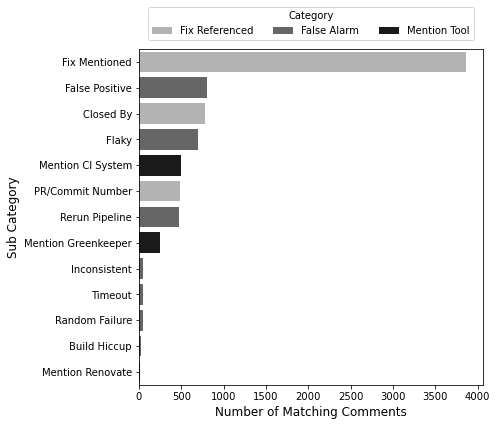

In [202]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
sns.barplot(
    data=for_plot,
    y='comment_sub_classification',
    x='count',
    hue='comment_classification',
    dodge=False,
    palette=['0.70', '0.4', '0.1'],
    ax=ax,
)
ax.set_ylabel('Sub Category', fontsize=12)
ax.set_xlabel('Number of Matching Comments', fontsize=12)

L = plt.legend(
    title='Category',
    loc='upper center',
    fancybox=True,
    bbox_to_anchor=(0.5,1.14),
    ncol=3,
    shadow=False,
)
save_fig('count_of_user_comment_matches')


plt.show()

In [138]:
users_comments[users_comments['comment_classification'] == NOT_CLASSIFIED].sample(50)[['lemm_body']]


,lemm_body
444,This look like breaking change nock increase min Node version 10 Someone using semver correctly Let's put hold
3796,Error jest2
2350,Making PR update dependency
8534,2751dc23341d4c86560fa7a3a9e297f795731f4a
4734,Looks like intermittent test failure Updated https://githubcom/blgm/jfq/pull/51
5915,using 20
6125,Bad installation directory per https://githubcom/99xt/serverless-dynamodb-local/issues/181 Just gonna let sit bit code get published
9473,Seems like maybe bug Mocha Can't reproduce 341 340 unpublished Doing PR update anyway
4695,Updated newer release latest Build
9677,See https://githubcom/tjoskar/ng-lazyload-image/commit/00efa043f2663d0338946b90ff24b3f5ea2a2c1f


In [ ]:
comments